# 赛题理解
[赛题链接](https://tianchi.aliyun.com/competition/entrance/231576/introduction)  
**赛题背景**：  
商家有时会在特定日期，例如Boxing-day，黑色星期五或是双十一（11月11日）开展大型促销活动或者发放优惠券以吸引消费者，然而很多被吸引来的买家都是一次性消费者，这些促销活动可能对销售业绩的增长并没有长远帮助，因此为解决这个问题，商家需要识别出哪类消费者可以转化为重复购买者。通过对这些潜在的忠诚客户进行定位，商家可以大大降低促销成本，提高投资回报率（Return on Investment, ROI）。众所周知的是，在线投放广告时精准定位客户是件比较难的事情，尤其是针对新消费者的定位。不过，利用天猫长期积累的用户行为日志，我们或许可以解决这个问题。  
我们提供了一些商家信息，以及在“双十一”期间购买了对应产品的新消费者信息。你的任务是预测给定的商家中，哪些新消费者在未来会成为忠实客户，即需要预测这些新消费者在6个月内再次购买的概率。    
**数据说明**：  
数据集主要包括在”双十一“之前和之后的六个月内，匿名用户购买的行为日志数据，用户的画像数据，以及相关的指示标签，标明其是否为重复购买用户。  
- 用户行为日志

|  字段名称   |                             描述                             |
| :---------: | :----------------------------------------------------------: |
|   user_id   |                      购物者的唯一ID编码                      |
|   item_id   |                      购物者的唯一ID编码                      |
|   cat_id    |                    商品所属品类的唯一编码                    |
| merchant_id |                       商家的唯一ID编码                       |
|  brand_id   |                      商品品牌的唯一编码                      |

|  time_tamp  |                    购买时间（格式：mmdd）                    |
| action_type | 包含{0, 1, 2, 3}，0表示单击，1表示添加到购物车，2表示购买，3表示添加到收藏夹 |   

- 用户画像

| 字段名称  |                             描述                             |
| :-------: | :----------------------------------------------------------: |
|  user_id  |                      购物者的唯一ID编码                      |
| age_range | 用户年龄范围。<18岁为1；[18,24]为2； [25,29]为3； [30,34]为4；[35,39]为5；[40,49]为6； > = 50时为7和8; 0和NULL表示未知 |
|  gender   |       用户性别。0表示女性，1表示男性，2和NULL表示未知        |

- 训练数据和测试数据

| 字段名称    |                             描述                             |
| ----------- | :----------------------------------------------------------: |
| user_id     |                      购物者的唯一ID编码                      |
| merchant_id |                       商家的唯一ID编码                       |
| label       | 包含{0, 1}，1表示重复买家，0表示非重复买家。测试集这一部分需要预测，因此为空。 |  


**评价指标**：  
$$
AUC = \cfrac{\sum_{i\in{positive Class}}rank_{i} - \cfrac{M(1+M)}{2}}{M*N}
$$
其中，M表示正样本个数，N表示负样本个数，AUC反映了<font color = "red">模型对正负样本排序能力的强弱</font>，对Score的大小和精度没有要求。  
**解题思路：**  
![](./imgs/解题思路.png)  


# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy
import gc
from collections import Counter
import warnings
from matplotlib import rcParams
config = {
    "font.family": 'Times New Roman',  # 设置字体类型
}
rcParams.update(config)
warnings.filterwarnings(action="ignore")


%matplotlib inline

In [2]:
# 数据存储情况
!tree data/data_format1/

data/data_format1/
├── test_format1.csv
├── train_format1.csv
├── user_info_format1.csv
└── user_log_format1.csv

0 directories, 4 files


In [3]:
# 问题：如何优化读入数据的内存占用情况？
# 解释内存

def reduce_mem(df):
    """对于数值类型的数据进行内存节省"""

    starttime = time.time()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2  # 统计内存使用情况

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.isnull(c_min) or pd.isnull(c_max):
                continue
            if str(col_type)[:3] == 'int':
                # 装换数据类型
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('-- Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction),time spend:{:2.2f} min'.format(end_mem,
                                                                                                    100 *
                                                                                                    (start_mem-end_mem)/start_mem,
                                                                                                    (time.time()-starttime)/60))
    return df

## 训练集

In [4]:
train_data = reduce_mem(pd.read_csv("./data/data_format1/train_format1.csv"))
train_data

-- Mem. usage decreased to  1.74 Mb (70.8% reduction),time spend:0.00 min


,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0
...,...,...,...
260859,359807,4325,0
260860,294527,3971,0
260861,294527,152,0
260862,294527,2537,0


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      260864 non-null  int32
 1   merchant_id  260864 non-null  int16
 2   label        260864 non-null  int8 
dtypes: int16(1), int32(1), int8(1)
memory usage: 1.7 MB


In [6]:
train_data.nunique()

user_id        212062
merchant_id      1993
label               2
dtype: int64

## 用户信息表

In [7]:
user_info = reduce_mem(pd.read_csv(
    "./data/data_format1/user_info_format1.csv"))
user_info

-- Mem. usage decreased to  3.24 Mb (66.7% reduction),time spend:0.00 min


,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0
...,...,...,...
424165,395814,3.0,1.0
424166,245950,0.0,1.0
424167,208016,NaN,NaN
424168,272535,6.0,1.0


In [8]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int32  
 1   age_range  421953 non-null  float16
 2   gender     417734 non-null  float16
dtypes: float16(2), int32(1)
memory usage: 3.2 MB


In [9]:
user_info.nunique()

user_id      424170
age_range         9
gender            3
dtype: int64

## 用户行为数据

In [7]:
# 问题：如何在pandas读取大批量的数据?
# 数据量过大，采用迭代方法, 此时占用内存存储空间为大约3GB
reader = pd.read_csv("./data/data_format1/user_log_format1.csv", iterator=True
                     )

loop = True
chunkSize = 100000
chunks = []

while loop:
    try:
        chunk = reader.get_chunk(chunkSize)
        chunks.append(chunk)
    except StopIteration:
        loop = False
        print("Iteration is stopped.")

df = pd.concat(chunks, ignore_index=True)
df.info()

Iteration is stopped.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   seller_id    int64  
 4   brand_id     float64
 5   time_stamp   int64  
 6   action_type  int64  
dtypes: float64(1), int64(6)
memory usage: 2.9 GB


In [19]:
chunks[1:3]

[        user_id  item_id  cat_id  seller_id  brand_id  time_stamp  action_type
 100000   376094    67897    1349        184    1360.0        1111            0
 100001   376094    67897    1349        184    1360.0        1111            0
 100002   376094    67897    1349        184    1360.0        1111            0
 100003   376094    67897    1349        184    1360.0        1111            0
 100004   376094    67897    1349        184    1360.0        1111            0
 ...         ...      ...     ...        ...       ...         ...          ...
 199995   201802   928615     320       3437    4827.0         610            0
 199996   201802   460769    1238       1102    1214.0        1107            0
 199997   201802   346680     662        793    3550.0        1107            0
 199998   201802   104980     664       1131    2350.0         529            0
 199999   201802   550411    1280       2468    1392.0        1109            0
 
 [100000 rows x 7 columns],
         u

In [13]:
user_log = reduce_mem(df)
user_log

-- Mem. usage decreased to 890.48 Mb (69.6% reduction),time spend:0.06 min


,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2660.0,829,0
1,328862,844400,1271,2882,2660.0,829,0
2,328862,575153,1271,2882,2660.0,829,0
3,328862,996875,1271,2882,2660.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0
...,...,...,...,...,...,...,...
54925325,208016,107662,898,1346,7996.0,1110,0
54925326,208016,1058313,898,1346,7996.0,1110,0
54925327,208016,449814,898,983,7996.0,1110,0
54925328,208016,634856,898,1346,7996.0,1110,0


In [14]:
user_log["user_id"].nunique()

424170

In [15]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int32  
 1   item_id      int32  
 2   cat_id       int16  
 3   seller_id    int16  
 4   brand_id     float16
 5   time_stamp   int16  
 6   action_type  int8   
dtypes: float16(1), int16(3), int32(2), int8(1)
memory usage: 890.5 MB


## 测试集信息表

In [14]:
test_data = reduce_mem(pd.read_csv("./data/data_format1/test_format1.csv"))
test_data

-- Mem. usage decreased to  3.49 Mb (41.7% reduction),time spend:0.00 min


,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN
...,...,...,...
261472,228479,3111,NaN
261473,97919,2341,NaN
261474,97919,3971,NaN
261475,32639,3536,NaN


In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261477 entries, 0 to 261476
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      261477 non-null  int32  
 1   merchant_id  261477 non-null  int16  
 2   prob         0 non-null       float64
dtypes: float64(1), int16(1), int32(1)
memory usage: 3.5 MB


## 缺失值

In [16]:
# user_log 用户日志表
Total = user_log.isnull().sum().sort_values(ascending=False)
percent = (user_log.isnull().sum()/user_log.isnull().count()
           ).sort_values(ascending=False)*100
missing_data = pd.concat([Total, percent], axis=1, keys=["Total", "Percent"])
missing_data

,Total,Percent
brand_id,91015,0.165707
user_id,0,0.000000
item_id,0,0.000000
cat_id,0,0.000000
seller_id,0,0.000000
time_stamp,0,0.000000
action_type,0,0.000000


结论：用户日志表中的特征信息缺失比例较小，且只出现在品牌一栏中，可以删除。

In [17]:
# user_info 用户信息表
Total = user_info.isnull().sum().sort_values(ascending=False)
percent = (user_info.isnull().sum()/user_info.isnull().count()
           ).sort_values(ascending=False)*100
missing_data = pd.concat([Total, percent], axis=1, keys=["Total", "Percent"])
missing_data

,Total,Percent
gender,6436,1.517316
age_range,2217,0.522668
user_id,0,0.000000


结论：用户信息表中，用户性别和年龄缺失，考虑此特征为类别特征，可以使用众数填补, 注意缺失值不止为NULL。

### 年龄缺失

In [164]:
# 年龄字段数据取值情况
user_info["age_range"].unique()

array([ 6.,  5.,  4.,  7.,  3.,  0.,  8.,  2., nan,  1.], dtype=float16)

In [165]:
# 年龄为零或为空为缺失值，缺失条目为95131条
user_info[(user_info["age_range"] == 0) | (
    user_info["age_range"].isna())].count()

user_id      95131
age_range    92914
gender       90664
dtype: int64

In [166]:
# 不同年龄段的缺失用户数量，不统计空值
user_info.groupby("age_range")[["user_id"]].count()

,user_id
age_range,
0.0,92914
1.0,24
2.0,52871
3.0,111654
4.0,79991
5.0,40777
6.0,35464
7.0,6992
8.0,1266


### 性别缺失

In [167]:
# 查看性别取值范围
user_info["gender"].unique()

array([ 1.,  0.,  2., nan], dtype=float16)

In [168]:
# 统计性别缺失情况
user_info[(user_info["gender"].isna()) | (user_info["gender"] == 2)].count()

user_id      16862
age_range    14664
gender       10426
dtype: int64

### 统计用户只有一个缺失值

In [169]:
# 注:count只统计非Nan的值，因此在user_id的数量能够表示真实的缺失数量
user_info[(user_info["gender"].isna()) | (user_info["gender"] == 2) | (
    user_info["age_range"] == 0) | (user_info["age_range"].isna())].count()

user_id      106330
age_range    104113
gender        99894
dtype: int64

## 正负样本统计

In [170]:
label_gp = train_data.groupby("label")["user_id"].count()
label_gp

label
0    244912
1     15952
Name: user_id, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

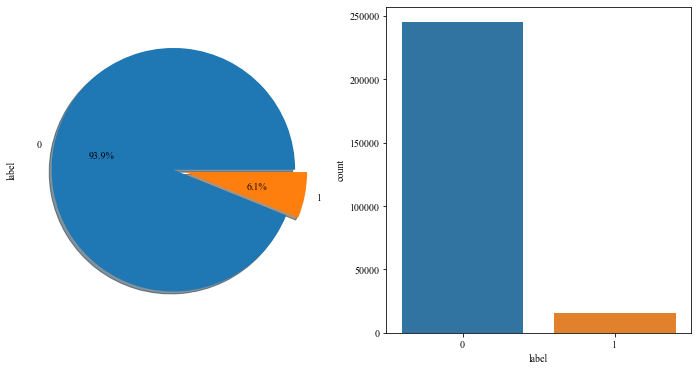

In [171]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
train_data["label"].value_counts().plot(kind="pie", ax=ax[0], shadow=True, explode=[0, 0.1], autopct="%1.1f%%"
                                        )

sns.countplot(x="label", data=train_data, ax=ax[1])

结论：样本极度不平衡，使用负采样或过采样技术调整数据不平衡的情况。  
[知识点: countplot](https://www.cnblogs.com/cymx66688/p/10536403.html)

## 探索影响复购的各种因素

### 分析不同店铺与复购的关系

<AxesSubplot:xlabel='merchant_id', ylabel='count'>

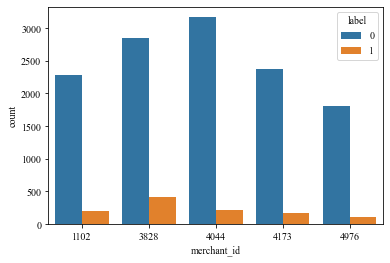

In [172]:
train_data_merchant = train_data.copy()
top5_idx = train_data_merchant.merchant_id.value_counts().head().index.tolist()
# 增加一列用于标记Top商户和非Top商户，便于统计其复购情况
train_data_merchant["Top5"] = train_data_merchant["merchant_id"].map(
    lambda x: 1 if x in top5_idx else 0)
train_data_merchant = train_data_merchant[train_data_merchant.Top5 == 1]

sns.countplot(x="merchant_id", hue="label", data=train_data_merchant)

结论：不同商铺复购情况大不相同，商铺复购率较低。

### 查看店铺的复购分布

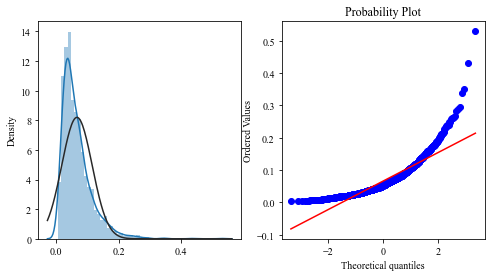

In [173]:
merchant_repeat_buy = [rate for rate in train_data.groupby(
    "merchant_id")["label"].mean() if rate <= 1 and rate > 0]
plt.figure(figsize=(8, 4))

ax1 = plt.subplot(1, 2, 1)
sns.distplot(merchant_repeat_buy, fit=scipy.stats.norm)

ax2 = plt.subplot(1, 2, 2)
res = scipy.stats.probplot(merchant_repeat_buy, plot=plt)

结论：用户店铺复购率分布在0.15左右，用户复购率较低，且不同店铺具有不同的复购率。（数据分布属于右偏）

### 查看用户的复购分布

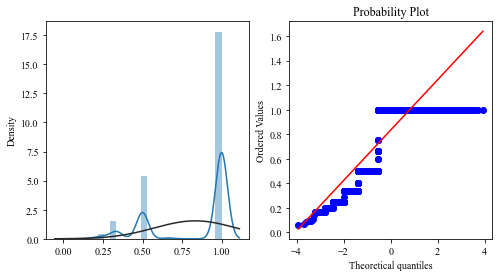

In [174]:
user_repeat_buy = [rate for rate in train_data.groupby(
    "user_id")["label"].mean() if rate <= 1 and rate > 0]

plt.figure(figsize=(8, 4))
ax1 = plt.subplot(1, 2, 1)
sns.distplot(user_repeat_buy, fit=scipy.stats.norm)

ax2 = plt.subplot(1, 2, 2)
res = scipy.stats.probplot(user_repeat_buy, plot=plt)

结论：近六个月的用户主要集中在一次购买为主，较少出现重复购买的情况。

### 对用户性别的分析

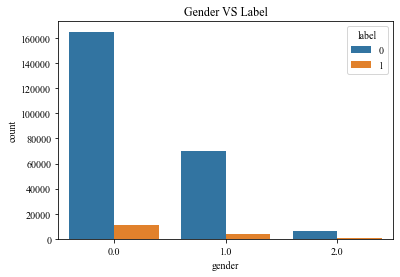

In [175]:
train_data_user_info = train_data.merge(user_info, on=["user_id"], how="left")

plt.figure(figsize=(6, 4))
plt.title("Gender VS Label")
ax = sns.countplot(x="gender", hue="label", data=train_data_user_info)
for p in ax.patches:
    hight = p.get_height()

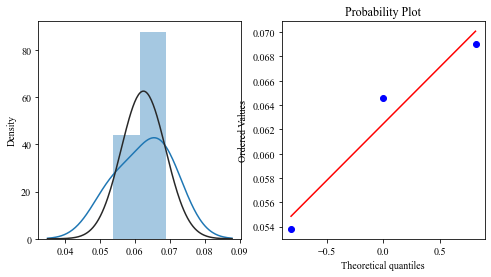

In [176]:
repeat_buy = [rate for rate in train_data_user_info.groupby(
    "gender")["label"].mean() if rate <= 1 and rate > 0]

plt.figure(figsize=(8, 4))
ax1 = plt.subplot(1, 2, 1)
sns.distplot(repeat_buy, fit=scipy.stats.norm)

ax2 = plt.subplot(1, 2, 2)
res = scipy.stats.probplot(repeat_buy, plot=plt)

结论：男女复购情况呈现差异性，女性购买情况远高于男性。

### 对用户年龄分析

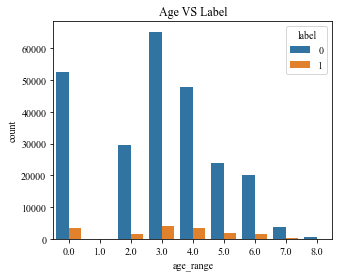

In [177]:
plt.figure(figsize=(5, 4))
plt.title("Age VS Label")
res = sns.countplot(x="age_range", hue="label", data=train_data_user_info)

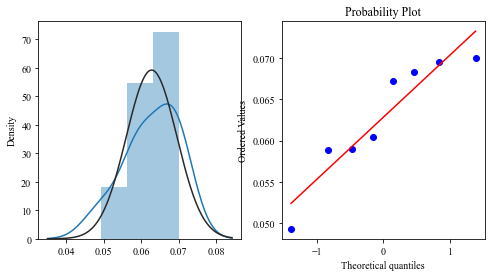

In [178]:
repeat_buy = [rate for rate in train_data_user_info.groupby(
    "age_range")["label"].mean() if rate <= 1 and rate > 0]

plt.figure(figsize=(8, 4))
ax1 = plt.subplot(1, 2, 1)
sns.distplot(repeat_buy, fit=scipy.stats.norm)

ax2 = plt.subplot(1, 2, 2)
res = scipy.stats.probplot(repeat_buy, plot=plt)

结论：用户在不同的年龄阶段复购情况有差异，年龄重点分布在25~34之间的用户。

# 特征工程

## 处理数据

In [179]:
# 全量信息处理,合并数据
all_data = train_data.append(test_data)
all_data = all_data.merge(user_info, on="user_id", how="left")
all_data.head()

,user_id,merchant_id,label,prob,age_range,gender
0,34176,3906,0.0,NaN,6.0,0.0
1,34176,121,0.0,NaN,6.0,0.0
2,34176,4356,1.0,NaN,6.0,0.0
3,34176,2217,0.0,NaN,6.0,0.0
4,230784,4818,0.0,NaN,0.0,0.0


In [183]:
user_log_copy = user_log.rename(columns={"seller_id": "merchant_id"})

In [188]:
user_log_copy

,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2660.0,829,0
1,328862,844400,1271,2882,2660.0,829,0
2,328862,575153,1271,2882,2660.0,829,0
3,328862,996875,1271,2882,2660.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0
...,...,...,...,...,...,...,...
54925325,208016,107662,898,1346,7996.0,1110,0
54925326,208016,1058313,898,1346,7996.0,1110,0
54925327,208016,449814,898,983,7996.0,1110,0
54925328,208016,634856,898,1346,7996.0,1110,0


In [186]:
# wewewwe
del train_data, test_data, user_info
gc.collect()

9230

In [35]:
# 对用户日志按照时间排序
user_log = user_log.sort_values(by=["user_id", "time_stamp"])

# 构建表达式(统计用户的历史信息)


def list_join_func(x): return " ".join(str(i) for i in x)


agg_dict = {
    "item_id": list_join_func,
    "cat_id": list_join_func,
    "seller_id": list_join_func,
    "brand_id": list_join_func,
    "time_stamp": list_join_func,
    "action_type": list_join_func
}

rename_dict = {
    "item_id": "item_path",
    "cat_id": "cat_path",
    "seller_id": "seller_path",
    "brand_id": "brand_path",
    "time_stamp": "time_stamp_path",
    "action_type": "action_type_path"
}

In [36]:
# 聚合用户历史购买行为
# user_log.groupby("user_id").agg(agg_dict)

In [37]:
def merge_list(df_ID, join_columns, df_data, agg_dict, rename_dict):
    """合并用户信息和日志信息"""

    # 构建用户历史记录
    df_data = df_data.groupby("user_id").agg(
        agg_dict).reset_index().rename(columns=rename_dict)

    df_ID = df_ID.merge(df_data, on=join_columns, how="left")

    return df_ID


all_date = merge_list(all_data, "user_id", user_log, agg_dict, rename_dict)

In [38]:
# 回收内存和删除不必要的数据
gc.collect()
del user_log

## 定义特征统计函数

### 定义统计函数

In [39]:
# 统计数据总数
def cnt_(x):

    try:
        return len(x.split(" "))
    except:
        return -1

In [40]:
# 统计唯一值数量
def nunique_(x):

    try:
        return len(set(x.split(" ")))
    except:
        return -1

In [41]:
# 统计数据最大值
def max_(x):

    try:
        return np.max([float(i) for i in x.split(" ")])
    except:
        return -1

In [42]:
# 统计数据最小值
def min_(x):

    try:
        return np.min([float(i) for i in x.split(" ")])
    except:
        return -1

In [43]:
# 统计数据标准差
def std_(x):

    try:
        return np.std([float(i) for i in x.split(" ")])
    except:
        return -1

In [44]:
# 统计TopN的数据
def most_n(x, n):

    try:
        return Counter(x.split(" ")).most_common(n)[n-1][0]  # 名称
    except:
        return -1


def most_n_cnt(x, n):

    try:
        return Counter(x.split(" ")).most_common(n)[n-1][1]  # 数量
    except:
        return -1

### 定义调用函数

In [45]:
def user_cnt(df_data, single_col, name):

    df_data[name] = df_data[single_col].apply(cnt_)

    return df_data

In [46]:
def user_nunique(df_data, single_col, name):

    df_data[name] = df_data[single_col].apply(nunique_)

    return df_data

In [47]:
def user_max(df_data, single_col, name):

    df_data[name] = df_data[single_col].apply(max_)

    return df_data

In [48]:
def user_min(df_data, single_col, name):

    df_data[name] = df_data[single_col].apply(min_)

    return df_data

In [49]:
def user_std(df_data, single_col, name):

    df_data[name] = df_data[single_col].apply(std_)

    return df_data

In [50]:
def user_cnt(df_data, single_col, name):

    df_data[name] = df_data[single_col].apply(cnt_)

    return df_data

In [51]:
def user_most_n(df_data, single_col, name, n=1):

    def func(x): return most_n(x, n)
    df_data[name] = df_data[single_col].apply(func)

    return df_data

In [52]:
def user_most_n_cnt(df_data, single_col, name, n=1):

    def func(x): return most_n_cnt(x, n)
    df_data[name] = df_data[single_col].apply(func)

    return df_data

### 提取统计变量(用户特征构造)

#### 统计用户的多样性

In [53]:
# 数据部分采样和全采样
# all_data_test = all_date.sample(2000)
all_data_test = all_date

In [54]:
# 每一位用户所点击的商铺总次数(不去重)
all_data_test = user_cnt(all_data_test, "seller_path", "user_seller_cnt")

# 店铺个数(去重)
all_data_test = user_nunique(
    all_data_test, "seller_path", "user_seller_unique")

# 不同种类
all_data_test = user_nunique(all_data_test, "cat_path", "user_cat_unique")

# 不同商品
all_data_test = user_nunique(all_data_test, "item_path", "user_item_unique")

# 不同品牌
all_data_test = user_nunique(all_data_test, "brand_path", "user_brand_unique")

# 活跃天数
all_data_test = user_nunique(
    all_data_test, "time_stamp_path", "user_time_stamp_unique")

# 用户不同行为的种类数目
all_data_test = user_nunique(
    all_data_test, "action_type_path", "user_action_type_unique")

In [55]:
# 查看构建特征对购买的影响情况
new_feature = ["user_seller_unique", "user_cat_unique", "user_item_unique",
               "user_brand_unique", "user_time_stamp_unique", "user_action_type_unique"]

for feature in new_feature:
    print("Feature:", feature)
    print(all_data_test.groupby("label")[feature].agg(["mean", "std"]))

Feature: user_seller_unique
            mean        std
label                      
0.0    35.447798  36.650101
1.0    37.904965  38.137931
Feature: user_cat_unique
            mean        std
label                      
0.0    23.878262  18.266488
1.0    26.464142  19.018367
Feature: user_item_unique
            mean         std
label                       
0.0    81.077354  110.089651
1.0    97.890797  128.547510
Feature: user_brand_unique
            mean        std
label                      
0.0    34.847149  34.815715
1.0    37.365848  36.349934
Feature: user_time_stamp_unique
            mean        std
label                      
0.0    17.391973  14.719989
1.0    19.992289  15.992401
Feature: user_action_type_unique
           mean       std
label                    
0.0    2.634301  0.551990
1.0    2.667503  0.537855


#### 时间类信息获取

In [56]:
# 最早时间
all_data_test = user_min(
    all_data_test, "time_stamp_path", "user_time_stamp_min")

# 最近时间
all_data_test = user_max(
    all_data_test, "time_stamp_path", "user_time_stamp_max")

# 用户点击时间间隔
all_data_test["time_stamp_range"] = all_data_test["user_time_stamp_max"] - \
    all_data_test["user_time_stamp_min"]

# 活跃天数的方差,描述用户的活跃的波动情况
all_data_test = user_std(
    all_data_test, "time_stamp_path", "user_time_stamp_std")

#### 其他基本信息

In [57]:
# 用户最喜欢的店铺
all_data_test = user_most_n(
    all_data_test, "seller_path", "user_seller_most_1", n=1)

# 用户最喜欢的类目
all_data_test = user_most_n(all_data_test, "cat_path", "user_cat_most_1", n=1)

# 用户最喜欢的品牌
all_data_test = user_most_n(
    all_data_test, "brand_path", "user_brand_most_1", n=1)

# 用户最常见的行为操作
all_data_test = user_most_n(
    all_data_test, "action_type_path", "user_action_type_1", n=1)

# 统计最喜欢的次数
# 用户最喜欢的店铺
all_data_test = user_most_n_cnt(
    all_data_test, "seller_path", "user_seller_most_1_cnt", n=1)

# 用户最喜欢的类目
all_data_test = user_most_n_cnt(
    all_data_test, "cat_path", "user_cat_most_1_cnt", n=1)

# 用户最喜欢的品牌
all_data_test = user_most_n_cnt(
    all_data_test, "brand_path", "user_brand_most_1_cnt", n=1)

# 用户最常见的行为操作
all_data_test = user_most_n_cnt(
    all_data_test, "action_type_path", "user_action_type_1_cnt", n=1)

#### 类别特征编码为哑变量

In [58]:
age_range = pd.get_dummies(all_data_test["age_range"], prefix="age")
gender = pd.get_dummies(all_data_test["gender"], prefix="gender")
all_data_test = all_data_test.join(age_range)
all_data_test = all_data_test.join(gender)

In [59]:
all_data_test.columns

Index(['user_id', 'merchant_id', 'label', 'prob', 'age_range', 'gender',
       'item_path', 'cat_path', 'seller_path', 'brand_path', 'time_stamp_path',
       'action_type_path', 'user_seller_cnt', 'user_seller_unique',
       'user_cat_unique', 'user_item_unique', 'user_brand_unique',
       'user_time_stamp_unique', 'user_action_type_unique',
       'user_time_stamp_min', 'user_time_stamp_max', 'time_stamp_range',
       'user_time_stamp_std', 'user_seller_most_1', 'user_cat_most_1',
       'user_brand_most_1', 'user_action_type_1', 'user_seller_most_1_cnt',
       'user_cat_most_1_cnt', 'user_brand_most_1_cnt',
       'user_action_type_1_cnt', 'age_0.0', 'age_1.0', 'age_2.0', 'age_3.0',
       'age_4.0', 'age_5.0', 'age_6.0', 'age_7.0', 'age_8.0', 'gender_0.0',
       'gender_1.0', 'gender_2.0'],
      dtype='object')

In [60]:
import copy


def col_cnt_(df_data, columns_list, action_type):
    """统计点击数量"""

    data_dict = {}
    try:
        col_list = copy.deepcopy(columns_list)

        if action_type != None:
            col_list += ["action_type_path"]

        for col in col_list:
            data_dict[col] = df_data[col].split(" ")

        path_len = len(data_dict[col])

        # {"sell_path": ["66", "55", ......]}
        data_out = []
        for i_ in range(path_len):
            data_txt = ""
            for col_ in columns_list:
                # 统计点击购买行为
                if data_dict["action_type_path"][i_] == action_type:
                    data_txt += "_" + data_dict[col_][i_]
            data_out.append(data_txt)

        return len(data_out)
    except:
        return -1

### 构建用户与商家的交互信息
例如：用户对商铺的点击行为特征，挖掘其是行为对点击情况的影响作用。

#### 用户的点击情况

In [61]:
# 消除重复点击
def col_unique_(df_data, columns_list, action_type):

    data_dict = {}
    try:
        col_list = copy.deepcopy(columns_list)

        if action_type != None:
            col_list += ["action_type_path"]

        for col in col_list:
            data_dict[col] = df_data[col].split(" ")

        path_len = len(data_dict[col])

        # {"sell_path": ["66", "55", ......], "action_type_path":["1", "0", "2", "3", "0",......]}
        data_out = []

        for i_ in range(path_len):
            data_txt = ""
            for col_ in columns_list:
                # 统计点击购买行为
                if data_dict["action_type_path"][i_] == action_type:
                    data_txt += "_" + data_dict[col_][i_]
            data_out.append(data_txt)

        return len(set(data_out))
    except:

        return -1

In [62]:
def user_col_cnt_(df_data, columns_list, action_type, name):

    df_data[name] = df_data.apply(lambda x: col_cnt_(
        x, columns_list, action_type), axis=1)

    return df_data


def user_col_unique_(df_data, columns_list, action_type, name):

    df_data[name] = df_data.apply(lambda x: col_unique_(
        x, columns_list, action_type), axis=1)

    return df_data

In [63]:
# 不同店铺的点击次数
all_data_test = user_col_cnt_(
    all_data_test, ["seller_path"], "1", "user_cnt_1")
all_data_test = user_col_cnt_(
    all_data_test, ["seller_path"], "0", "user_cnt_0")
all_data_test = user_col_cnt_(
    all_data_test, ["seller_path"], "2", "user_cnt_2")
all_data_test = user_col_cnt_(
    all_data_test, ["seller_path"], "3", "user_cnt_3")

In [64]:
# 店铺唯一值
all_data_test = user_col_unique_(
    all_data_test, ["seller_path"], "0", "user_unique_0")
all_data_test = user_col_unique_(
    all_data_test, ["seller_path"], "1", "user_unique_1")
all_data_test = user_col_unique_(
    all_data_test, ["seller_path"], "2", "user_unique_2")
all_data_test = user_col_unique_(
    all_data_test, ["seller_path"], "3", "user_unique_3")

#### 统计用户历史对该商品的评分

In [65]:
def user_merchant_mark(df_data, merchant_id, seller_path, action_type_path, action_type):
    """统计历史用户的打分情况"""

    sell_len = len(df_data[seller_path].split(" "))
    data_dict = {}
    data_dict[seller_path] = df_data[seller_path].split(" ")
    data_dict[action_type_path] = df_data[action_type_path].split(" ")

    # 遍历历史商铺数据访问数据
    mark = 0
    for i in range(sell_len):
        if data_dict[seller_path][i] == str(df_data[merchant_id]):
            if data_dict[action_type_path][i] == action_type:
                mark += 1
    return 0

In [66]:
def user_merchant_mark_all(user_data, merchant_id, seller_path, action_type_path, action_type, name):
    """统计所有用户的点击情况"""

    user_data[name + "_" + action_type] = user_data.apply(lambda x: user_merchant_mark(
        x, merchant_id, seller_path, action_type_path, action_type), axis=1)

    return user_data

In [67]:
# 用户针对此商家有多少次 0、1、2、3动作
all_data_test = user_merchant_mark_all(
    all_data_test, 'merchant_id', 'seller_path', 'action_type_path', '0', 'user_merchant_action')
all_data_test = user_merchant_mark_all(
    all_data_test, 'merchant_id', 'seller_path', 'action_type_path', '1', 'user_merchant_action')
all_data_test = user_merchant_mark_all(
    all_data_test, 'merchant_id', 'seller_path', 'action_type_path', '2', 'user_merchant_action')
all_data_test = user_merchant_mark_all(
    all_data_test, 'merchant_id', 'seller_path', 'action_type_path', '3', 'user_merchant_action')

In [68]:
all_data_test.columns

Index(['user_id', 'merchant_id', 'label', 'prob', 'age_range', 'gender',
       'item_path', 'cat_path', 'seller_path', 'brand_path', 'time_stamp_path',
       'action_type_path', 'user_seller_cnt', 'user_seller_unique',
       'user_cat_unique', 'user_item_unique', 'user_brand_unique',
       'user_time_stamp_unique', 'user_action_type_unique',
       'user_time_stamp_min', 'user_time_stamp_max', 'time_stamp_range',
       'user_time_stamp_std', 'user_seller_most_1', 'user_cat_most_1',
       'user_brand_most_1', 'user_action_type_1', 'user_seller_most_1_cnt',
       'user_cat_most_1_cnt', 'user_brand_most_1_cnt',
       'user_action_type_1_cnt', 'age_0.0', 'age_1.0', 'age_2.0', 'age_3.0',
       'age_4.0', 'age_5.0', 'age_6.0', 'age_7.0', 'age_8.0', 'gender_0.0',
       'gender_1.0', 'gender_2.0', 'user_cnt_1', 'user_cnt_0', 'user_cnt_2',
       'user_cnt_3', 'user_unique_0', 'user_unique_1', 'user_unique_2',
       'user_unique_3', 'user_merchant_action_0', 'user_merchant_action_1',

In [69]:
all_data_test["user_merchant_action_1"].value_counts

<bound method IndexOpsMixin.value_counts of 0         0
1         0
2         0
3         0
4         0
         ..
522336    0
522337    0
522338    0
522339    0
522340    0
Name: user_merchant_action_1, Length: 522341, dtype: int64>

### 提取统计变量(商铺特征构造)

In [59]:
# user_log_test = user_log.sample(2000)
user_log_test = user_log

In [71]:
# 构建表达式(统计用户的历史信息)
def list_join_func(x): return " ".join(str(i) for i in x)


agg_seller_dict = {
    "item_id": list_join_func,
    "cat_id": list_join_func,
    "brand_id": list_join_func,
    "user_id": list_join_func,
    "time_stamp": list_join_func,
    "action_type": list_join_func
}

rename_seller_dict = {
    "item_id": "item_path",
    "cat_id": "cat_path",
    "user_id": "user_path",
    "brand_id": "brand_path",
    "time_stamp": "time_stamp_path",
    "action_type": "action_type_path"
}

#### 商铺基本信息
例如：访问人数、商品种类数目、商铺中的品牌数目

In [72]:
# 构建商品信息表
user_log_seller = user_log_test.groupby("seller_id").agg(
    agg_seller_dict).reset_index().rename(columns=rename_seller_dict)

# 统计商铺被用户点击的总次数
user_log_seller = user_cnt(user_log_seller, "user_path", "seller_user_cnt")

# 统计商铺有多少不同消费着（上一步去重）
user_log_seller = user_nunique(
    user_log_seller, "user_path", "seller_user_unique")

# 商铺有多少种类商品
user_log_seller = user_nunique(
    user_log_seller, "cat_path", "seller_cat_unique")

# 商铺有多少不同的商品
user_log_seller = user_nunique(
    user_log_seller, "item_path", "seller_item_unique")

# 商铺有多少不同的品牌
user_log_seller = user_nunique(
    user_log_seller, "brand_path", "seller_brand_unique")

# 商铺被点击的时间相差天数
user_log_seller = user_nunique(
    user_log_seller, "action_type_path", "seller_action_type_unique")

#### 商铺时间信息

In [73]:
# 最早时间
user_log_seller = user_min(
    user_log_seller, "time_stamp_path", "seller_time_stamp_min")

# 最近时间
user_log_seller = user_max(
    user_log_seller, "time_stamp_path", "seller_time_stamp_max")

# 用户点击时间间隔
user_log_seller["seller_time_stamp_range"] = user_log_seller["seller_time_stamp_max"] - \
    user_log_seller["seller_time_stamp_min"]

# 活跃天数的方差,描述商铺被访问时间的活跃的波动情况
user_log_seller = user_std(
    user_log_seller, "time_stamp_path", "seller_user_time_stamp_std")

# 商铺被点击的时间活跃天数(商铺的活跃度)
user_log_seller = user_nunique(
    user_log_seller, "time_stamp_path", "seller_time_stamp_unique")

#### 商铺被点击信息

In [74]:
# 统计商品被点击情况
def user_action_cnt(df_data, col_action, action_type, name):

    def func(x): return len([i for i in x.split(' ') if i == action_type])
    df_data[name+'_'+action_type] = df_data[col_action].apply(func)
    return df_data

In [75]:
user_log_seller = user_action_cnt(
    user_log_seller, "action_type_path", "1", "seller_cnt_1")
user_log_seller = user_action_cnt(
    user_log_seller, "action_type_path", "0", "seller_cnt_0")
user_log_seller = user_action_cnt(
    user_log_seller, "action_type_path", "2", "seller_cnt_2")
user_log_seller = user_action_cnt(
    user_log_seller, "action_type_path", "3", "seller_cnt_3")

## 合并数据

In [76]:
user_log_seller = user_log_seller.rename(columns={"seller_id": "merchant_id"})
seller_features = [c for c in user_log_seller.columns if c not in
                   ["item_path", "cat_path", "user_path", "brand_path", "time_stamp_path", "action_type_path"]]

user_log_seller = user_log_seller[seller_features]

all_data_test = all_data_test.merge(
    user_log_seller, on="merchant_id", how="left")

In [77]:
all_data_test.columns

Index(['user_id', 'merchant_id', 'label', 'prob', 'age_range', 'gender',
       'item_path', 'cat_path', 'seller_path', 'brand_path', 'time_stamp_path',
       'action_type_path', 'user_seller_cnt', 'user_seller_unique',
       'user_cat_unique', 'user_item_unique', 'user_brand_unique',
       'user_time_stamp_unique', 'user_action_type_unique',
       'user_time_stamp_min', 'user_time_stamp_max', 'time_stamp_range',
       'user_time_stamp_std', 'user_seller_most_1', 'user_cat_most_1',
       'user_brand_most_1', 'user_action_type_1', 'user_seller_most_1_cnt',
       'user_cat_most_1_cnt', 'user_brand_most_1_cnt',
       'user_action_type_1_cnt', 'age_0.0', 'age_1.0', 'age_2.0', 'age_3.0',
       'age_4.0', 'age_5.0', 'age_6.0', 'age_7.0', 'age_8.0', 'gender_0.0',
       'gender_1.0', 'gender_2.0', 'user_cnt_1', 'user_cnt_0', 'user_cnt_2',
       'user_cnt_3', 'user_unique_0', 'user_unique_1', 'user_unique_2',
       'user_unique_3', 'user_merchant_action_0', 'user_merchant_action_1',

## 隐含特征挖掘

### 嵌入特征

In [78]:
# import gensim

In [79]:
# sentences = all_data_test["seller_path"].apply(lambda x: x.split(" "))
# model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)

In [80]:
# # 求解每一个用户的喜欢商品的嵌入特征的平均值
# def mean_w2v_(x, model, size=100):
#     """加和求平均"""

#     try:
#         i = 0
#         for word in x.split(" "):
#             if word in model.wv.vocab:
#                 i += 1
#                 if i == 1:
#                     vec = np.zeros(size)
#                 vec += model.wv[word]
#         return vec/i
#     except:
#         return np.zeros(size)

# def get_mean_w2v(df_data, columns, model, size):
#     """获取所有用户的平均向量"""

#     data_array = []
#     for index, data in df_data.iterrows():
#         w2v = mean_w2v_(data[columns], model, size)
#         data_array.append(w2v)

#     return pd.DataFrame(data_array)

In [81]:
# # 获取embedding向量
# df_emmbedding = get_mean_w2v(all_data_test, "seller_path", model, 100)
# df_emmbedding.columns = ["embedding_" + str(i) for i in df_emmbedding.columns]
# df_emmbedding

In [82]:
# 合并嵌入特征
# all_data_test = pd.concat([all_data_test, df_emmbedding], axis=1)

In [83]:
all_data_test.to_csv("./data/all_data_test.csv", index=False)

# 特征优化
目的：优化数据，接近模型上限

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score as AUC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
# 是否从本地读取数据
all_data_test = pd.read_csv("./data/all_data_test.csv")

In [4]:
feature_columns = [c for c in all_data_test.columns if c not in ["label", "prob", "age_range", "gender",
                                                                 'item_path', 'cat_path', 'seller_path', 'brand_path', 'time_stamp_path', 'action_type_path']]

In [5]:
train = all_data_test[~all_data_test.label.isna()][:10000]

In [6]:
x_train = train[feature_columns]
y_train = train["label"].values
x_test = all_data_test[all_data_test.label.isna()][feature_columns]

In [7]:
# 缺失数值为类别数据，采用众数填补
imputer = SimpleImputer(strategy="median")
imputer = imputer.fit(x_train)
train_imputer = imputer.transform(x_train)
test_imputer = imputer.transform(x_test)

In [8]:
def select_feature(train, train_sel, target):

    clf = RandomForestClassifier(max_depth=2, random_state=2021, n_jobs=-1
                                 )
    score1 = cross_val_score(clf, train, target, cv=5, scoring="roc_auc")
    score2 = cross_val_score(clf, train_sel, target, cv=5, scoring="roc_auc")
    print("No Select AUC: %0.3f (+/- %0.3f)" %
          (score1.mean(), score1.std()**2))
    print("Feature Select AUC: %0.3f (+/- %0.3f)" %
          (score2.mean(), score2.std()**2))
    print("特征选择前特征维度：", train_imputer.shape)
    print("特征选择后特征维度：", train_sel.shape)

In [9]:
select_feature(x_train, train_imputer, target=y_train)

No Select AUC: nan (+/- nan)
Feature Select AUC: 0.572 (+/- 0.000)
特征选择前特征维度： (10000, 60)
特征选择后特征维度： (10000, 60)


## 方差分析法

In [13]:
from sklearn.feature_selection import VarianceThreshold

In [14]:
threshold_range = np.arange(0, 1, 0.1)
for i in threshold_range:
    print("Values is :", i)
    sel = VarianceThreshold(threshold=i)
    train_sel = sel.fit_transform(train_imputer)
    select_feature(train_imputer, train_sel, y_train)

Values is : 0.0
No Select AUC: 0.572 (+/- 0.000)
Feature Select AUC: 0.576 (+/- 0.000)
特征选择前特征维度： (10000, 60)
特征选择后特征维度： (10000, 56)
Values is : 0.1
No Select AUC: 0.572 (+/- 0.000)
Feature Select AUC: 0.577 (+/- 0.000)
特征选择前特征维度： (10000, 60)
特征选择后特征维度： (10000, 47)
Values is : 0.2
No Select AUC: 0.572 (+/- 0.000)
Feature Select AUC: 0.578 (+/- 0.000)
特征选择前特征维度： (10000, 60)
特征选择后特征维度： (10000, 42)
Values is : 0.30000000000000004
No Select AUC: 0.572 (+/- 0.000)
Feature Select AUC: 0.579 (+/- 0.000)
特征选择前特征维度： (10000, 60)
特征选择后特征维度： (10000, 39)
Values is : 0.4
No Select AUC: 0.572 (+/- 0.000)
Feature Select AUC: 0.577 (+/- 0.000)
特征选择前特征维度： (10000, 60)
特征选择后特征维度： (10000, 38)
Values is : 0.5
No Select AUC: 0.572 (+/- 0.000)
Feature Select AUC: 0.577 (+/- 0.000)
特征选择前特征维度： (10000, 60)
特征选择后特征维度： (10000, 38)
Values is : 0.6000000000000001
No Select AUC: 0.572 (+/- 0.000)
Feature Select AUC: 0.577 (+/- 0.000)
特征选择前特征维度： (10000, 60)
特征选择后特征维度： (10000, 38)
Values is : 0.7000000000000001
No Sele

## 递归功能消除法

In [16]:
from sklearn.feature_selection import RFECV

clf = RandomForestClassifier(max_depth=2, random_state=2021, n_jobs=-1
                             )

selector = RFECV(clf, step=1, cv=2)
selector = selector.fit(train_imputer, y_train)

KeyboardInterrupt: 

## 使用模型选择特征
注意：模型必须coef_或feature_importance属性

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression

### L1选择

In [96]:
# 数据归一化
normalize = Normalizer()
normalize = normalize.fit(train_imputer)
train_norm = normalize.transform(train_imputer)
test_norm = normalize.transform(test_imputer)

In [97]:
LR = LogisticRegression(penalty="l1", C=5, solver="saga")
LR = LR.fit(train_norm, y_train)
model = SelectFromModel(LR, prefit=True)
train_sel = model.transform(train_norm)
test_sel = model.transform(test_norm)

In [98]:
select_feature(train_imputer, train_sel, y_train)

No Select AUC: 0.572 (+/- 0.000)
Feature Select AUC: 0.552 (+/- 0.000)
特征选择前特征维度： (10000, 60)
特征选择后特征维度： (10000, 11)


### L2选择

In [99]:
LR = LogisticRegression(penalty="l2", C=5)
LR = LR.fit(train_norm, y_train)
model = SelectFromModel(LR, prefit=True)
train_sel = model.transform(train_norm)
test_sel = model.transform(test_norm)

In [100]:
select_feature(train_imputer, train_sel, y_train)

No Select AUC: 0.572 (+/- 0.000)
Feature Select AUC: 0.550 (+/- 0.000)
特征选择前特征维度： (10000, 60)
特征选择后特征维度： (10000, 14)


# 建立模型

In [9]:
from sklearn.model_selection import KFold
from scipy import sparse
import xgboost
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss, mean_absolute_error, mean_squared_error
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

## 数据处理

In [3]:
all_data_test = pd.read_csv("./data/all_data_test.csv")

In [4]:
# 有用特征提取
feature_columns = [c for c in all_data_test.columns if c not in ["label", "prob", "gender", "age_range",
                                                                 'item_path', 'cat_path', 'seller_path', 'brand_path', 'time_stamp_path', 'action_type_path']]

In [5]:
x_train = all_data_test[~all_data_test.label.isna()][feature_columns]
y_train = all_data_test[~all_data_test.label.isna()]["label"].values
x_test = all_data_test[all_data_test.label.isna()][feature_columns]

In [6]:
# 空值用零填补
# def get_matrix(data):

#     where_are_nan = np.isnan(data)
#     where_are_inf = np.isinf(data)
#     data[where_are_nan] = 0
#     data[where_are_inf] = 0

#     return data

# X = np.float_(get_matrix(np.float_()))

# x_test = np.float_(get_matrix(np.float_(x_test)))

In [12]:
# 缺失值用中位数填补
imputer = SimpleImputer(strategy="median")
imputer = imputer.fit(x_train)
X = imputer.transform(x_train)
x_test = imputer.transform(x_test)
y = np.int_(y_train)

In [13]:
# # 方差过滤优化特征
# vart = VarianceThreshold(0.3)
# vart = vart.fit(X=X)
# X = vart.transform(X)
# x_test = vart.transform(x_test)

In [14]:
# 分层抽取样本(保证数据划分后的样本数目相同)
# 构造训练集和测试集
def trainData(train_df, label_df):
    skv = StratifiedKFold(n_splits=5, shuffle=True, random_state=620)
    trainX = pd.DataFrame()
    trainY = pd.DataFrame()
    testX = pd.DataFrame()
    testY = pd.DataFrame()
    for train_index, test_index in skv.split(X=train_df, y=label_df):
        train_x, train_y, test_x, test_y = train_df.iloc[train_index, :], label_df.iloc[train_index], \
            train_df.iloc[test_index, :], label_df.iloc[test_index]

        trainX = trainX.append(train_x)
        trainY = trainY.append(train_y)
        testX = testX.append(test_x)
        testY = testY.append(test_y)
        break

    return trainX, trainY, testX, testY

In [15]:
trainNew, label = pd.DataFrame(X), pd.DataFrame(y)
X_train, y_train, X_val, y_val = trainData(trainNew, label)

## RandomForest

In [19]:
# RF =RandomForestClassifier().fit(X_train, y_train)

In [20]:
# RF.score(X_test, y_test)

## LightGBM

In [16]:
# 数据准备
cv_train = lgb.Dataset(X, y)
data_train = lgb.Dataset(X_train, y_train)
data_val = lgb.Dataset(X_val, y_val)

### 网格搜索寻找参数范围（粗调）

In [17]:
from sklearn.model_selection import GridSearchCV
from time import time
import datetime
import sklearn
import joblib
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score as AUC

In [28]:
class GridSearch:
    """回归模型网格搜索"""

    def __init__(self, model):
        self.model = model

    def grid_get(self, X, y, param_grid):
        """参数搜索"""

        grid_search = GridSearchCV(self.model, param_grid=param_grid, scoring="roc_auc", cv=5, n_jobs=-1
                                   )
        grid_search.fit(X, y)
        print("Best_params:", grid_search.best_params_,
              "best_score_:", (grid_search.best_score_))
        print(pd.DataFrame(grid_search.cv_results_)[
              ["params", "mean_test_score", "std_test_score"]])

        return grid_search.best_estimator_

In [36]:
[sklearn.metrics.SCORERS.keys()]

[dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_we

In [37]:
param_grid = {
    #      "num_leaves": np.arange(31, 82, 7)
    #     , "max_depth": np.arange(5, 7, 8, 6)
    , "learning_rate": [0.1, 0.01, 0.03], "n_estimators": [1000, 3000, 6000]
    #     , "subsample":[0.8, 0.9, 1.0]
    #     , "colsample_bytree":[0.8, 0.9, 1.0]
}

In [115]:
t0 = time()
LGBC = lgb.LGBMClassifier(boosting_type="gbdt", device="gpu"  # , learning_rate=0.01
                          #                           , num_leaves=41
                          #                           , max_depth=6

                          #                           , subsample=0.8
                          #                           , colsample_bytree=0.8
                          #                           , n_estimators=2000
                          , metric="auc", random_state=0, silent=True
                          )
model = GridSearch(LGBC).grid_get(X=X_train, y=y_train, param_grid=param_grid)
print("处理时间：", datetime.datetime.fromtimestamp(time()-t0).strftime("%M:%S:%f"))

Best_params: {'learning_rate': 0.1} best_score_: 0.6512223331632725
                   params  mean_test_score  std_test_score
0  {'learning_rate': 0.1}         0.651222        0.001596
处理时间： 02:20:432963


In [116]:
model.score(X_val, y_val)

0.9391387682085357

In [117]:
probs = model.predict(X_val)
area = AUC(y_val, probs)
area

0.5000981728567914

### 默认参数（精调）

In [29]:
# 参数设定为默认状态
params1 = {
    "boosting_type": "gbdt", "objective": "binary"  # 二分类任务
    , "metric": {"binary_logloss", "auc"}, "nthread": 16, "device": "gpu", "gpu_device_id": 1, "num_gpu": 1, "verbose": 0, "learning_rate": 0.1, "subsample": 1.0  # 数据采样
    #     , "subsample_freq": 5
    , "colsample_bytree": 1.0  # 特征采样

    , "max_depth": 5  # , "min_child_weight": 1.5
    , "num_leaves": 16  # 由于lightGBM是leaves_wise生长，官方说法是要小于2^max_depth
    , 'reg_alpha': 0.0  # L1
    , 'reg_lambda': 0.0  # L2
    , "seed": 2021
}

In [30]:
cv_result1 = lgb.cv(params=params1, train_set=cv_train, nfold=5, stratified=True, shuffle=True, num_boost_round=600, early_stopping_rounds=100, seed=2021
                    )

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### 参数调整完毕

In [18]:
num_boost_round = 600
params2 = {
    "boosting_type": "gbdt", "objective": "binary"  # 二分类任务
    , "metric": {"binary_logloss", "auc"}, "nthread": 16, "device": "gpu", "gpu_device_id": 1, "num_gpu": 1, "verbose": 0, "learning_rate": 0.01, "subsample": 0.8  # 数据采样
    #     , "subsample_freq": 5
    , "colsample_bytree": 0.8  # 特征采样

    , "max_depth": 5  # , "min_child_weight": 1.5
    , "num_leaves": 15  # 由于lightGBM是leaves_wise生长，官方说法是要小于2^max_depth
    , 'reg_alpha': 0.0  # L1
    , 'reg_lambda': 0.0  # L2
    , "seed": 2021
}

In [19]:
cv_result2 = lgb.cv(params=params2, train_set=cv_train, num_boost_round=num_boost_round, nfold=5, stratified=True, shuffle=True, early_stopping_rounds=100, seed=2021
                    )

In [36]:
#  选择最佳的estimators
print("Best_n_estimators: %d\nBest_cv_score: %.2f"
      % (np.array(list(cv_result2.values())).shape[1],
         max(np.array(list(cv_result2.values()))[0]))
      )

Best_n_estimators: 600
Best_cv_score: 0.23


### 调参状态

In [37]:
params3 = {
    "boosting_type": "gbdt", "objective": "binary"  # 二分类任务
    , "metric": {"binary_logloss", "auc"}, "nthread": 16, "device": "gpu", "gpu_device_id": 1, "num_gpu": 1, "verbose": 0, "learning_rate": 0.01, "subsample": 1  # 数据采样
    #     , "subsample_freq": 5
    , "colsample_bytree": 1  # 特征采样

    , "max_depth": 7  # , "min_child_weight": 1.5
    , "num_leaves": 80  # 由于lightGBM是leaves_wise生长，官方说法是要小于2^max_depth
    , 'reg_alpha': 0.0  # L1
    , 'reg_lambda': 0.0  # L2
    , "seed": 2021
}

In [38]:
cv_result3 = lgb.cv(params=params3, train_set=cv_train, num_boost_round=10000, nfold=5, stratified=True, shuffle=True, early_stopping_rounds=100, seed=2021
                    )

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### 可视化

In [39]:
def plot_mertics(cv_result1, cv_result2, cv_result3, index1=0, index2=1, save=False):
    """绘制评估曲线"""

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    length1 = np.array(list(cv_result1.values())).shape[1]
    length2 = np.array(list(cv_result2.values())).shape[1]
    length3 = np.array(list(cv_result3.values())).shape[1]

    ax[0].plot(range(length1), cv_result1[list(
        cv_result1.keys())[index1]], label="param1", c="red")
    ax[1].plot(range(length1), cv_result1[list(cv_result1.keys())
                                          [index2]], label="param1", c="green")

    ax[0].plot(range(length2), cv_result2[list(cv_result2.keys())
                                          [index1]], label="param2", c="magenta")
    ax[1].plot(range(length2), cv_result2[list(cv_result2.keys())
                                          [index2]], label="param2", c="blue")

    ax[0].plot(range(length3), cv_result3[list(cv_result3.keys())
                                          [index1]], label="param3", c="yellow")
    ax[1].plot(range(length3), cv_result3[list(
        cv_result3.keys())[index2]], label="param3", c="c")

    ax[0].set_xlabel("num_round", fontsize=12)
    ax[1].set_xlabel("num_round", fontsize=12)
    ax[0].set_ylabel(list(cv_result1.keys())[index1], fontsize=12)
    ax[1].set_ylabel(list(cv_result1.keys())[index2], fontsize=12)
    ax[0].legend()
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()
    if save:
        plt.savefig(
            "./imgs/{}.svg".format(list(cv_result1.keys())[index1].split("-")[0]))

    plt.show()

#### AUC评估

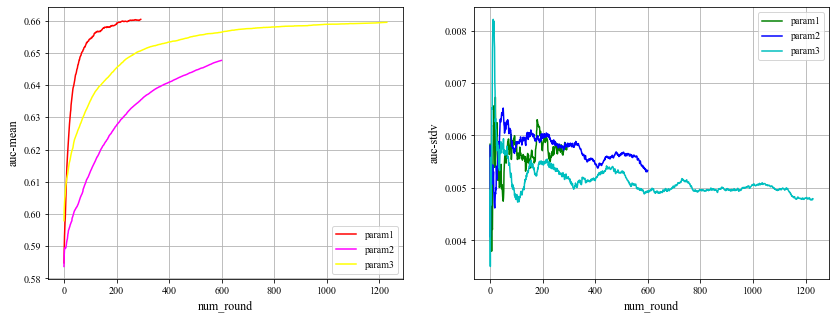

In [40]:
plot_mertics(cv_result1, cv_result2, cv_result3, index1=2, index2=3, save=True)

####　Logloss评估

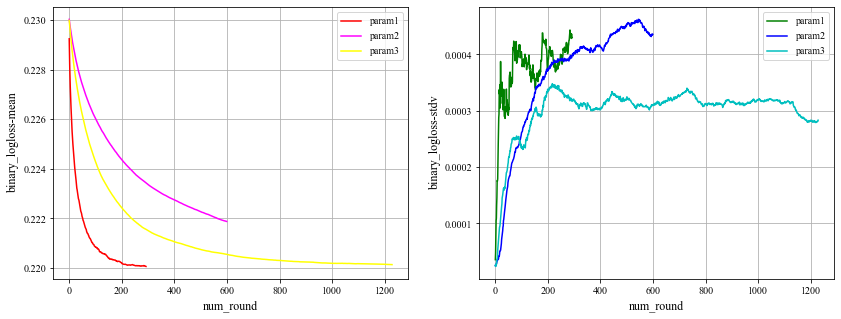

In [41]:
plot_mertics(cv_result1, cv_result2, cv_result3, save=True)

### 模型评估与保存

In [20]:
"""
当使用验证集，并加入早停机制时，可以设置在多少步之内，若评估指标不在下降
，则提前终止训练模型，多个评估指标使用时，每一个评估指标都可作为终止的条件
"""
lgb_C = lgb.train(params=params2, train_set=data_train, valid_sets=data_val, num_boost_round=10000, early_stopping_rounds=200, valid_names="valid"
                  )

[1]	valid's binary_logloss: 0.230003	valid's auc: 0.583351
Training until validation scores don't improve for 200 rounds
[2]	valid's binary_logloss: 0.229915	valid's auc: 0.588539
[3]	valid's binary_logloss: 0.229839	valid's auc: 0.589903
[4]	valid's binary_logloss: 0.229769	valid's auc: 0.589381
[5]	valid's binary_logloss: 0.229697	valid's auc: 0.589572
[6]	valid's binary_logloss: 0.229627	valid's auc: 0.589717
[7]	valid's binary_logloss: 0.229556	valid's auc: 0.58946
[8]	valid's binary_logloss: 0.229489	valid's auc: 0.588832
[9]	valid's binary_logloss: 0.229424	valid's auc: 0.589263
[10]	valid's binary_logloss: 0.229351	valid's auc: 0.589644
[11]	valid's binary_logloss: 0.229288	valid's auc: 0.589721
[12]	valid's binary_logloss: 0.229213	valid's auc: 0.590758
[13]	valid's binary_logloss: 0.229156	valid's auc: 0.59061
[14]	valid's binary_logloss: 0.229089	valid's auc: 0.591384
[15]	valid's binary_logloss: 0.229033	valid's auc: 0.591739
[16]	valid's binary_logloss: 0.228981	valid's auc

In [21]:
# AUC指标
probs = lgb_C.predict(X_val, num_iteration=lgb_C.best_iteration)
FPR, recall, thresholds = roc_curve(y_val, probs, pos_label=1)
area = AUC(y_val, probs)
area

0.6641842602036392

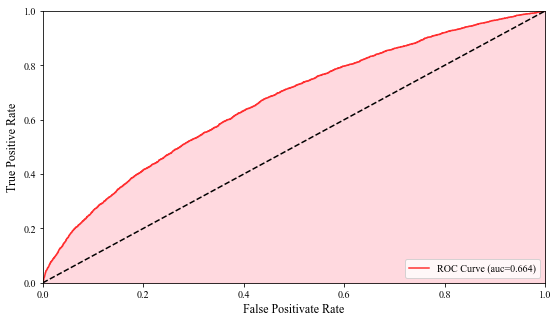

In [22]:
plt.figure(figsize=(9, 5))
plt.plot(FPR, recall, color="red",
         label="ROC Curve (auc=%0.3f)" % (area), alpha=0.8)
plt.plot([0, 1], [0, 1], c="black", linestyle="--")
plt.xlim([-0.0, 1])
plt.ylim([-0.0, 1])
plt.fill_between(FPR, recall, [0.0]*len(recall), alpha=0.6, color="pink")
plt.xlabel('False Positivate Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right")
plt.show()

In [23]:
# 提交格式
submission = pd.read_csv("data/sample_submission.csv")
submission["prob"] = lgb_C.predict(x_test)
submission.to_csv("submission.csv", index=False)

In [24]:
!head -n 5 submission.csv

user_id,merchant_id,prob
163968,4605,0.09125727959606986
360576,1581,0.062254484804112636
98688,1964,0.07093595769358127
98688,3645,0.0402129725164242


In [25]:
#　模型保存
# lgb_C.save_model("./checkpoint/model.txt")

## LightGBM+LR

In [26]:
num_leaves = 15

#  训练集
y_pred = lgb_C.predict(
    X_train, num_iteration=lgb_C.best_iteration, pred_leaf=True)

print('Writing transformed training data')
transformed_training_matrix = np.zeros([len(y_pred), len(y_pred[0]) * num_leaves],
                                       dtype=np.int64)
for i in range(0, len(y_pred)):
    temp = np.arange(len(y_pred[0])) * num_leaves + np.array(y_pred[i])
    transformed_training_matrix[i][temp] += 1
print('X_train leaf', transformed_training_matrix.shape)

#  测试集
y_pred = lgb_C.predict(X_val, pred_leaf=True,
                       num_iteration=lgb_C.best_iteration)

print('Writing transformed testing data')
transformed_testing_matrix = np.zeros(
    [len(y_pred), len(y_pred[0]) * num_leaves], dtype=np.int64)
for i in range(0, len(y_pred)):
    temp = np.arange(len(y_pred[0])) * num_leaves + np.array(y_pred[i])
    transformed_testing_matrix[i][temp] += 1
    if i == 0:
        break
print('testing leaf shape', transformed_testing_matrix.shape)

Writing transformed training data
X_train leaf (208691, 51555)
Writing transformed testing data
testing leaf shape (52173, 51555)


In [ ]:
lm = LogisticRegression(penalty='l2', C=0.05)  # logestic model construction
lm.fit(transformed_training_matrix, y_train)  # fitting the data

In [ ]:
probs = lm.predict(transformed_testing_matrix)
FPR, recall, thresholds = roc_curve(y_val, probs, pos_label=1)
area = AUC(y_val, probs)
area

结论：时间复杂高，准确率低。

## DIEN

### 数据预处理

In [251]:
all_data = pd.read_csv("data/all_data_test.csv")

In [252]:
# 删除无用特征
drop_columns = []
for name in all_data.columns:
    if "path" in name or "gender_" in name or name in age_range.columns.tolist() or "merchant_action" in name:
        continue

    drop_columns.append(name)
all_data = all_data[drop_columns]

In [253]:
# 打印唯一值
def print_nuniuqe(data):

    for name in data.columns.tolist()[:-1]:
        print(name+":", data[name].nunique())


print_nuniuqe(all_data)

user_id: 424170
merchant_id: 1994
label: 2
prob: 0
age_range: 9
gender: 3
user_seller_cnt: 2157
user_seller_unique: 489
user_cat_unique: 205
user_item_unique: 1333
user_brand_unique: 450
user_time_stamp_unique: 153
user_action_type_unique: 4
user_time_stamp_min: 184
user_time_stamp_max: 2
time_stamp_range: 186
user_time_stamp_std: 419742
user_seller_most_1: 4986
user_cat_most_1: 922
user_brand_most_1: 3101
user_action_type_1: 4
user_seller_most_1_cnt: 970
user_cat_most_1_cnt: 864
user_brand_most_1_cnt: 965
user_action_type_1_cnt: 2036
user_cnt_1: 2157
user_cnt_0: 2157
user_cnt_2: 2157
user_cnt_3: 2157
user_unique_0: 475
user_unique_1: 17
user_unique_2: 102
user_unique_3: 223
seller_user_cnt: 1856
seller_user_unique: 1597
seller_cat_unique: 92
seller_item_unique: 562
seller_brand_unique: 53
seller_action_type_unique: 2
seller_time_stamp_min: 139
seller_time_stamp_max: 2
seller_time_stamp_range: 140
seller_user_time_stamp_std: 1994
seller_time_stamp_unique: 161
seller_cnt_1_1: 130
seller

In [255]:
all_data.columns

Index(['user_id', 'merchant_id', 'label', 'prob', 'age_range', 'gender',
       'user_seller_cnt', 'user_seller_unique', 'user_cat_unique',
       'user_item_unique', 'user_brand_unique', 'user_time_stamp_unique',
       'user_action_type_unique', 'user_time_stamp_min', 'user_time_stamp_max',
       'time_stamp_range', 'user_time_stamp_std', 'user_seller_most_1',
       'user_cat_most_1', 'user_brand_most_1', 'user_action_type_1',
       'user_seller_most_1_cnt', 'user_cat_most_1_cnt',
       'user_brand_most_1_cnt', 'user_action_type_1_cnt', 'user_cnt_1',
       'user_cnt_0', 'user_cnt_2', 'user_cnt_3', 'user_unique_0',
       'user_unique_1', 'user_unique_2', 'user_unique_3', 'seller_user_cnt',
       'seller_user_unique', 'seller_cat_unique', 'seller_item_unique',
       'seller_brand_unique', 'seller_action_type_unique',
       'seller_time_stamp_min', 'seller_time_stamp_max',
       'seller_time_stamp_range', 'seller_user_time_stamp_std',
       'seller_time_stamp_unique', 'seller

In [256]:
spase_columns = ['user_id', 'merchant_id', 'age_range', 'gender']
dense_columns = ['user_seller_cnt', 'user_seller_unique', 'user_cat_unique',
                 'user_item_unique', 'user_brand_unique', 'user_time_stamp_unique',
                 'user_action_type_unique', 'user_time_stamp_min', 'user_time_stamp_max',
                 'time_stamp_range', 'user_time_stamp_std', 'user_seller_most_1',
                 'user_cat_most_1', 'user_brand_most_1', 'user_action_type_1',
                 'user_seller_most_1_cnt', 'user_cat_most_1_cnt',
                 'user_brand_most_1_cnt', 'user_action_type_1_cnt', 'user_cnt_1',
                 'user_cnt_0', 'user_cnt_2', 'user_cnt_3', 'user_unique_0',
                 'user_unique_1', 'user_unique_2', 'user_unique_3', 'seller_user_cnt',
                 'seller_user_unique', 'seller_cat_unique', 'seller_item_unique',
                 'seller_brand_unique', 'seller_action_type_unique',
                 'seller_time_stamp_min', 'seller_time_stamp_max',
                 'seller_time_stamp_range', 'seller_user_time_stamp_std',
                 'seller_time_stamp_unique', 'seller_cnt_1_1', 'seller_cnt_0_0',
                 'seller_cnt_2_2', 'seller_cnt_3_3']

In [257]:
# 标准化
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

lb = LabelEncoder()
mm = MinMaxScaler()
# 连续特征
for name in dense_columns:
    all_data[name] = mm.fit_transform(all_data[[name]])

# 类别特征
for name in spase_columns:
    all_data[name] = lb.fit_transform(all_data[name])

In [260]:
all_data["hist_merchant_id"] = all_data[[
    "user_id", "merchant_id"]].groupby("user_id").agg({list})

In [263]:
all_data["hist_merchant_id"]

0              [378]
1         [695, 652]
2              [905]
3              [446]
4             [1239]
             ...    
522336           NaN
522337           NaN
522338           NaN
522339           NaN
522340           NaN
Name: hist_merchant_id, Length: 522341, dtype: object

In [220]:
!echo $(date)

+08 2021 оны Тавдугаар сар 2, Ня 17:38:14


# 参考
[使用Python Pandas处理亿级数据](https://cloud.tencent.com/developer/article/1054025)  
[LightGBM官方文档](https://lightgbm.readthedocs.io/en/latest/index.html)  
[探索SMOTE算法](https://zhuanlan.zhihu.com/p/275744968)

# 知识点

## KFold和StrartifiedFold的区别

In [69]:
from sklearn.model_selection import KFold
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]])
y = np.array([1, 2, 3, 4, 5, 6])

kf = KFold(n_splits=3, shuffle=True)    # 定义分成几个组

# for循环中的train_index与test_index是索引而并非我们的训练数据
for train_index, test_index in kf.split(X):
    print("Train Index:", train_index, ",Test Index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Train Index: [0 1 3 4] ,Test Index: [2 5]
Train Index: [0 2 3 5] ,Test Index: [1 4]
Train Index: [1 2 4 5] ,Test Index: [0 3]


In [88]:
from sklearn.model_selection import StratifiedKFold

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]])
y = np.array([1, 1, 1, 2, 2, 2])
# 类似于分层抽样保证拆分后的数据，正负样本比例保持一致
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=2021)

# for循环中的train_index与test_index是索引而并非我们的训练数据
for train_index, test_index in skf.split(X, y):

    print("Train Index:", train_index, ",Test Index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Train Index: [0 1 3 5] ,Test Index: [2 4]
Train Index: [0 2 3 4] ,Test Index: [1 5]
Train Index: [1 2 4 5] ,Test Index: [0 3]
